In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

### Load sequences

In [2]:
import gzip
import numpy as np
from vakai import dinuc_shuffle
def load_sequences(seqfile):
    labels = []
    seqs = []
    fp = gzip.open(seqfile, "rb")
    print("#Loading " + seqfile + " ...")
    for line in fp:
        line=line.decode('utf8').split()
        labels.append(line[0])
        seqs.append(line[1])
    fp.close()
    print("#Loaded " + str(len(seqs)) + " sequences from " + seqfile)
    return labels, seqs

In [3]:
import h5py
original_labels, original_seqs=load_sequences('/users/eprakash/git/interpret-benchmark/scripts/top_10k_no_implant_neg_sim_positives.txt.gz')
rng = np.random.RandomState(1234)
dn_shuff_seqs=[dinuc_shuffle.dinuc_shuffle(s=seq, rng=rng) for seq in original_seqs]
print(len(dn_shuff_seqs))

#Loading /users/eprakash/git/interpret-benchmark/scripts/top_10k_no_implant_neg_sim_positives.txt.gz ...
#Loaded 10000 sequences from /users/eprakash/git/interpret-benchmark/scripts/top_10k_no_implant_neg_sim_positives.txt.gz
10000


### Onehot encode data

In [4]:
#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
#sequences = sequences[-5000:]            
original_onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in original_seqs])
dn_onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in dn_shuff_seqs])

In [5]:
print(original_onehot_data.shape)
print(dn_onehot_data.shape)

(10000, 400, 4)
(10000, 400, 4)


### Load keras model

In [7]:
import deeplift
import keras
from keras.models import model_from_json
import tensorflow as tf

with tf.device('/gpu:2'):
    keras_model_weights = "/users/eprakash/git/interpret-benchmark/data/dnase_positives/momma_dragonn_config/model_files/no_implant_neg/spe_100/record_1_model_P2JZo_modelWeights.h5"
    keras_model_json = "/users/eprakash/git/interpret-benchmark/data/dnase_positives/momma_dragonn_config/model_files/no_implant_neg/spe_100/record_1_model_P2JZo_modelJson.json"

    keras_model = model_from_json(open(keras_model_json).read())
    keras_model.load_weights(keras_model_weights)
    intermediate_layer_model = keras.models.Model(input=keras_model.input, output=keras_model.layers[-2].output)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



/users/eprakash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=Tensor("ne...)`
  if sys.path[0] == '':


In [8]:
original_logits = intermediate_layer_model.predict(original_onehot_data)
dn_logits = intermediate_layer_model.predict(dn_onehot_data)

original_logits=np.squeeze(original_logits,axis=1)
dn_logits=np.squeeze(dn_logits,axis=1)

### Interpolation

In [9]:
alpha=0.01
logits=[]

for index in range(0,len(original_seqs)):
    reference=dn_onehot_data[index]
    actual=original_onehot_data[index]
    seq_logits=[]
    for step_number in range(0,int(1/alpha)):
        step_size=alpha*(step_number+1)
        interpolated=(1-step_size)*reference + step_size*actual
        interpolated_logit=intermediate_layer_model.predict(interpolated[None,:])
        seq_logits.append(interpolated_logit)
    logits.append(seq_logits)

In [10]:
logits=np.array(logits)
logits=np.squeeze(logits,axis=3)
logits=np.squeeze(logits,axis=2)

In [11]:
print(logits.shape)

(10000, 100)


### Plot logit distribution

PREDICTIONS DENSITY PLOT


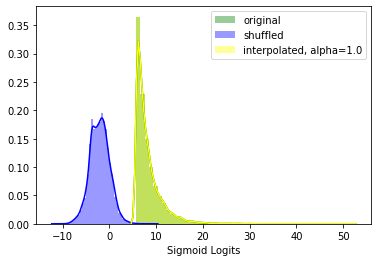

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
column=99
print("PREDICTIONS DENSITY PLOT")
sns.distplot(original_logits, color='green', label="original", axlabel="Sigmoid Logits")
sns.distplot(dn_logits, color='blue', label="shuffled",)
sns.distplot(logits[:,column], color='yellow', label="interpolated, alpha="+str(alpha*(column+1)))
plt.legend(loc = 'upper right')
plt.show()